## Config

In [1]:
# parameters
INPUT_DATA_PATH = "../data/interim/"
INPUT_PROCESSED_DATA_PATH = "../data/processed/"

YEAR = 2024
SAVE_OUTPUT = True
OUTPUT_DATA_PATH = "../data/interim/expansion_factors"


In [2]:
# Parameters
YEAR = 2024
SAVE_OUTPUT = True


In [3]:
# Import all necessary libraries
import time
start = time.time()
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import seaborn as sns

import warnings
from pathlib import Path


# Load data

In [4]:
#Read observations by hour 
counters_hour = pd.read_parquet(Path(INPUT_DATA_PATH) / f'cleaned_data{YEAR}.parquet')

# Explore the data (shape, columns, head, etc)
print(counters_hour.shape)
print(counters_hour.columns)
counters_hour.head()

(2484288, 11)
Index(['Id_aforament', 'date', 'hour', 'intensity', 'prev_hour_count',
       'Daily_Counts', 'duration', 'Number_of_hrs_data_collected', 'day',
       'month', 'Number_of_days_data_collected'],
      dtype='object')


,Id_aforament,date,hour,intensity,prev_hour_count,Daily_Counts,duration,Number_of_hrs_data_collected,day,month,Number_of_days_data_collected
0,20001,2024-01-01,00,126.0,NaN,3461.0,1,24,1,1,25
1,20001,2024-01-01,01,138.0,NaN,3461.0,1,24,1,1,25
2,20001,2024-01-01,02,103.0,NaN,3461.0,1,24,1,1,25
3,20001,2024-01-01,03,95.0,NaN,3461.0,1,24,1,1,25
4,20001,2024-01-01,04,76.0,NaN,3461.0,1,24,1,1,25


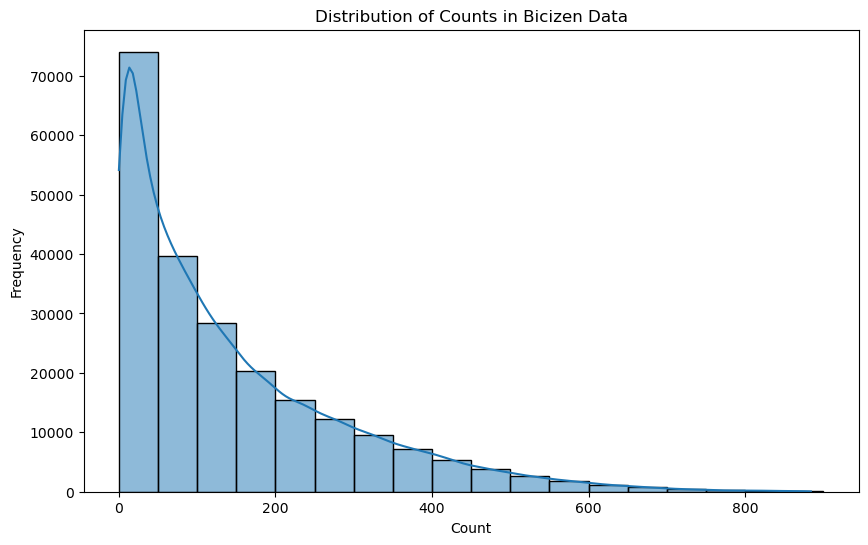

In [5]:
test=counters_hour[counters_hour["month"]==11]

# Create a histogram for the 'Count' column in the bicizen dataset
plt.figure(figsize=(10, 6))
sns.histplot(test['intensity'], binwidth=50, kde=True)
plt.title('Distribution of Counts in Bicizen Data')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [6]:
test['intensity'].describe()

count    223176.000000
mean        145.055902
std         146.744925
min           0.000000
25%          32.000000
50%          96.000000
75%         215.000000
max         884.000000
Name: intensity, dtype: float64

## Fix formats

In [7]:
counters_hour.rename(columns={'Id_aforament': 'id'}, inplace=True)
counters_hour["intensity"] = counters_hour["intensity"].astype(int)
#Make date column datetime
counters_hour['date'] = pd.to_datetime(counters_hour['date'])
counters_hour["weekday"] = counters_hour["date"].dt.weekday
counters_hour["hour"] = counters_hour["hour"].astype(int)
counters_hour["year"] = counters_hour["date"].dt.year

In [8]:
essential_attributes = [
    'id',
    'date', 
    'weekday', 
    'hour', 
    'intensity', 
    'month', 
    'year',
    'day'
]
data_ex = counters_hour[essential_attributes].copy()

# Expansion factors Of Permanent Counters


This study first calculated the following expansion factors for all the permanent counters, then grouped 6 the permanent sites within the same travel pattern based on traffic distribution indices (PHI, WWI, SF, and SRR). 

## Calculate Expansion Factors

### Hour of Day (HOD) factor

The HOD factor is the ratio between the average traffic in a given hour of the day and the average daily traffic. HOD was calculated separately for weekdays and weekends

In [9]:
#Separate data by weekday & weekend
weekday = data_ex[data_ex["weekday"]<5]
weekend = data_ex[data_ex["weekday"]>4]

print(data_ex.shape)
print(weekday.shape)
print(weekend.shape)
print("Adds up:",data_ex.shape[0]-(weekday.shape[0]+weekend.shape[0]))


(2484288, 8)
(1748184, 8)
(736104, 8)
Adds up: 0


In [10]:
#Weekday expansion factors
# Calculate average hourly traffic for weekdays
hod_weekday_avg = pd.DataFrame({'Average_HOD': weekday.groupby(['id', 'year', 'hour'])['intensity'].mean()}).reset_index()

# Calculate the sum of average hourly traffic for each counter and year
hod_weekday_sum = pd.DataFrame({'sum_of_Average_HOD': hod_weekday_avg.groupby(['id', 'year'])['Average_HOD'].sum()}).reset_index()

# Merge the dataframes to calculate the HOD factor
hod_weekday = pd.merge(hod_weekday_avg, hod_weekday_sum, left_on=['id', 'year'], right_on=['id', 'year'], how='inner')
hod_weekday['HOD'] = hod_weekday['Average_HOD'] / hod_weekday['sum_of_Average_HOD']

hod_weekday.head()

,id,year,hour,Average_HOD,sum_of_Average_HOD,HOD
0,20001,2024,0,152.438017,4115.090909,0.037044
1,20001,2024,1,71.842975,4115.090909,0.017458
2,20001,2024,2,34.921488,4115.090909,0.008486
3,20001,2024,3,20.586777,4115.090909,0.005003
4,20001,2024,4,14.541322,4115.090909,0.003534


In [11]:
#Weekend expansion factors
# Calculate average hourly traffic for weekdays
hod_weekend_avg = pd.DataFrame({'Average_HOD': weekend.groupby(['id', 'year', 'hour'])['intensity'].mean()}).reset_index()

# Calculate the sum of average hourly traffic for each counter and year
hod_weekend_sum = pd.DataFrame({'sum_of_Average_HOD': hod_weekend_avg.groupby(['id', 'year'])['Average_HOD'].sum()}).reset_index()

# Merge the dataframes to calculate the HOD factor
hod_weekend = pd.merge(hod_weekend_avg, hod_weekend_sum, left_on=['id', 'year'], right_on=['id', 'year'], how='inner')
hod_weekend['HOD'] = hod_weekend['Average_HOD'] / hod_weekend['sum_of_Average_HOD']

hod_weekend.head()


,id,year,hour,Average_HOD,sum_of_Average_HOD,HOD
0,20001,2024,0,225.980198,3442.0,0.065654
1,20001,2024,1,130.029703,3442.0,0.037777
2,20001,2024,2,79.455446,3442.0,0.023084
3,20001,2024,3,56.752475,3442.0,0.016488
4,20001,2024,4,33.178218,3442.0,0.009639


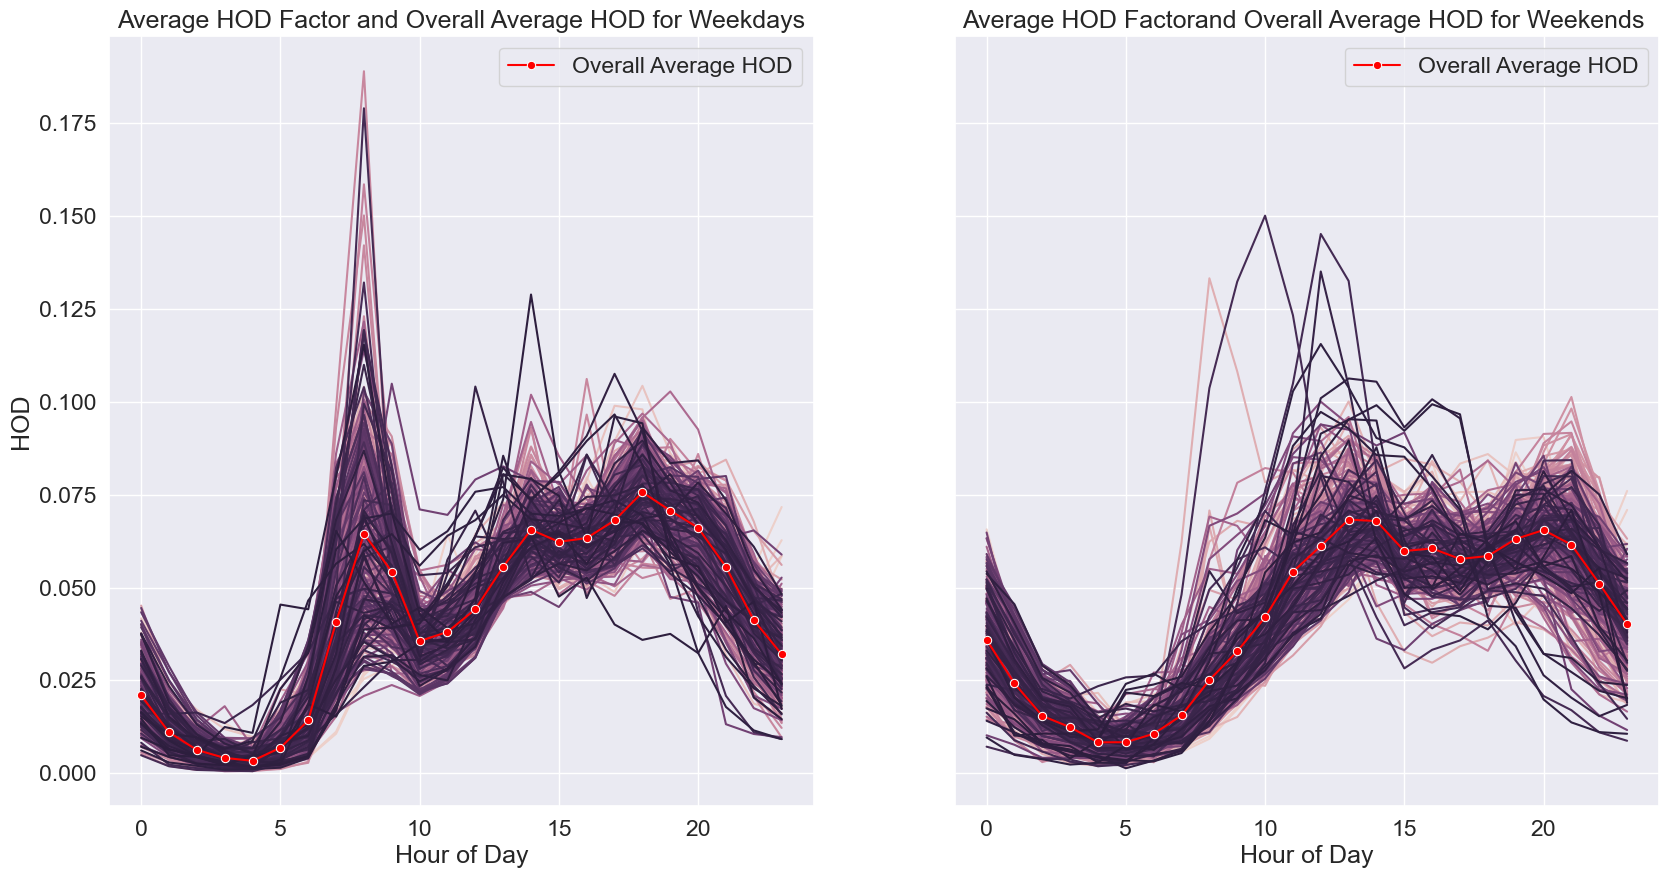

In [12]:
# Set plot parameters
sns.set(rc={'figure.figsize': (20, 10)})
sns.set(font_scale=1.5)

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Plot for weekdays
sns.lineplot(x='hour', y='HOD', hue='id', data=hod_weekday, dashes=False, sort=True, ax=ax1, legend=False)
average_hod_weekday = hod_weekday.groupby('hour')['HOD'].mean().reset_index()
sns.lineplot(x='hour', y='HOD', data=average_hod_weekday, markers=True, marker="o", dashes=False, sort=True, ax=ax1, color='red', label='Overall Average HOD')
ax1.set_title('Average HOD Factor and Overall Average HOD for Weekdays')
ax1.set_ylabel('HOD')
ax1.set_xlabel('Hour of Day')

# Plot for weekends
sns.lineplot(x='hour', y='HOD', hue='id', data=hod_weekend, dashes=False, sort=True, ax=ax2, legend=False)
average_hod_weekend = hod_weekend.groupby('hour')['HOD'].mean().reset_index()
sns.lineplot(x='hour', y='HOD', data=average_hod_weekend, markers=True, marker="o", dashes=False, sort=True, ax=ax2, color='red', label='Overall Average HOD')
ax2.set_title('Average HOD Factorand Overall Average HOD for Weekends ')
ax2.set_ylabel('HOD')
ax2.set_xlabel('Hour of Day')

# Show plot
plt.show()


### Day of Week (DOW) factor


The DOW factor is the ratio of the average traffic on a particular day of the week and the average total traffic for the week.

In [13]:
# Calculate and merge the daily average volume and average total weekly volume
daily_avg_volume = pd.DataFrame({'daily_avg_volume': counters_hour.groupby(['id', 'year', 'weekday'])['intensity'].mean()}).reset_index()
total_weekly_volume = pd.DataFrame({'total_weekly_volume': daily_avg_volume.groupby(['id', 'year'])['daily_avg_volume'].sum()}).reset_index()
dow_factor = pd.merge(daily_avg_volume, total_weekly_volume, left_on=['id', 'year'], right_on=['id', 'year'], how='inner')


# Define the categories for the days of the week
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)

# Assuming 'dow_factor' is the dataframe containing the necessary columns
dow_factor['Day of Week'] = dow_factor['weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
dow_factor['Day of Week'] = dow_factor['Day of Week'].astype(cat_type)

# Calculate the Day of Week (DOW) factor
dow_factor['DOW'] = dow_factor['daily_avg_volume'] / dow_factor['total_weekly_volume']

# Display the head of the dataframe
dow_factor.head()

,id,year,weekday,daily_avg_volume,total_weekly_volume,Day of Week,DOW
0,20001,2024,0,155.848639,1144.221469,Monday,0.136205
1,20001,2024,1,169.300833,1144.221469,Tuesday,0.147962
2,20001,2024,2,172.729610,1144.221469,Wednesday,0.150958
3,20001,2024,3,184.870748,1144.221469,Thursday,0.161569
4,20001,2024,4,174.792553,1144.221469,Friday,0.152761


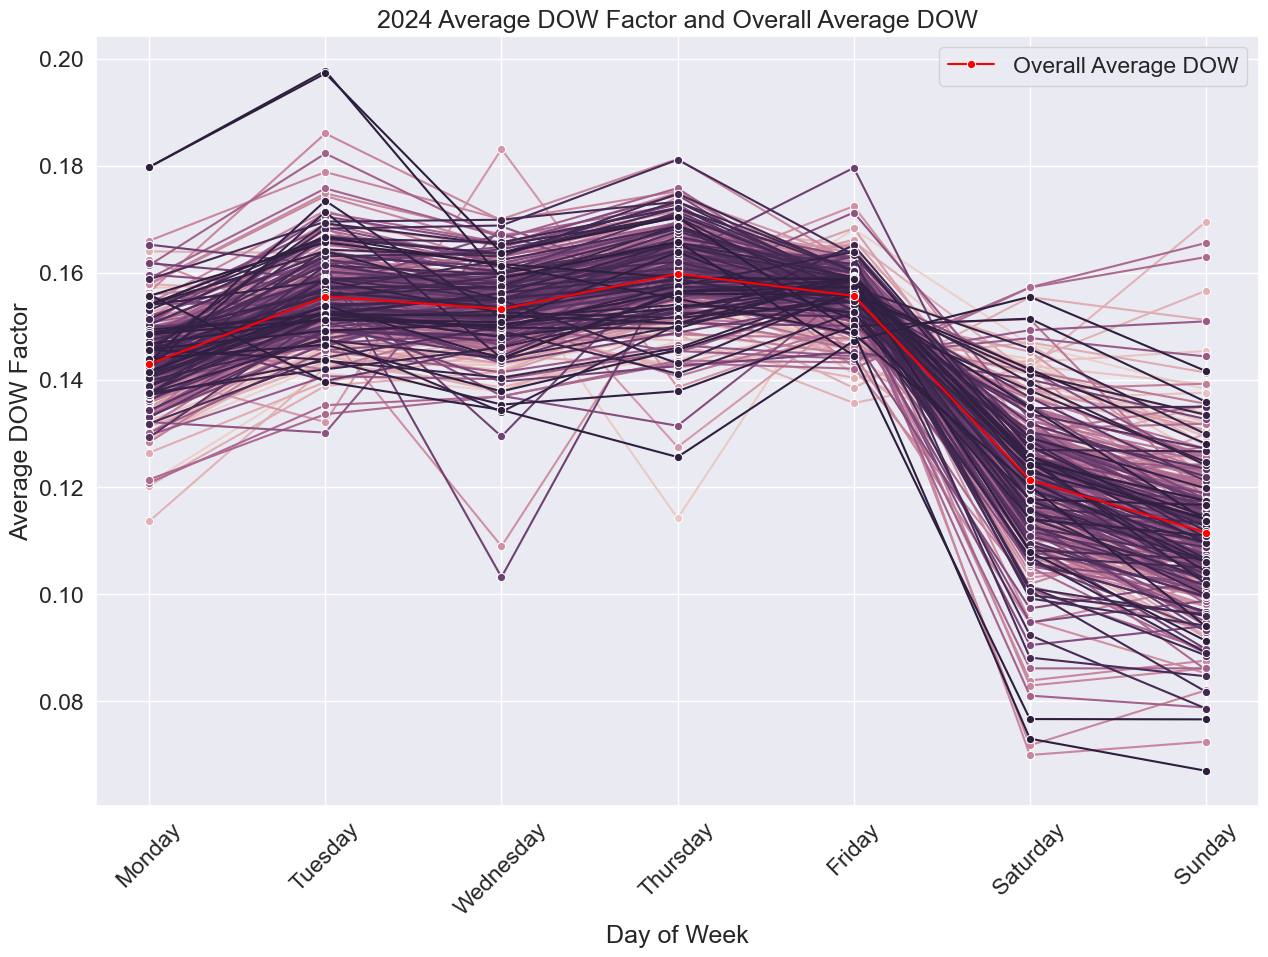

In [14]:
# Filter data for the specified YEAR
data_year = dow_factor.loc[dow_factor['year'] == YEAR]

# Set plot parameters
sns.set(rc={'figure.figsize': (15, 10)})
sns.set(font_scale=1.5)

# Create the plot
fig, ax = plt.subplots()

# Plot data for the specified year
sns.lineplot(x='Day of Week', y='DOW', hue='id', data=data_year, markers=True, marker="o", dashes=False, sort=True, ax=ax, legend=False)

# Calculate and plot the average MOY
average_dow = dow_factor.groupby('Day of Week')['DOW'].mean().reset_index()
sns.lineplot(x='Day of Week', y='DOW', data=average_dow, markers=True, marker="o", dashes=False, sort=True, ax=ax, color='red', label='Overall Average DOW')

# Set title
ax.title.set_text(f'{YEAR} Average DOW Factor and Overall Average DOW')

# Rotate x-axis labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Set axis labels
ax.set_ylabel('Average DOW Factor')
ax.set_xlabel('Day of Week')

# Show plot
plt.show()


### Month of Year (MOY) factor

The MOY factor is the ratio of monthly and annual total traffic.

In [15]:
# Calculate the number of months of data for each counter
data_ex['month_count'] = data_ex.groupby('id')['month'].transform('nunique')

# Filter the counters with more than 11 months of data
filtered_data_ex = data_ex[data_ex['month_count'] > 11]

# Drop the 'month_count' column as it is no longer needed
filtered_data_ex = filtered_data_ex.drop(columns=['month_count'])

# Calculate Monthly Total Traffic (MTT)
monthly_total_traffic = pd.DataFrame({'MTT': filtered_data_ex.groupby(['id', 'year', 'month'])['intensity'].sum()}).reset_index()

# Calculate Annual Total Traffic (ATT)
annual_total_traffic = pd.DataFrame({'ATT': monthly_total_traffic.groupby(['id', 'year'])['MTT'].sum()}).reset_index()

# Merge MTT and ATT
moy_factor = pd.merge(monthly_total_traffic, annual_total_traffic, on=['id', 'year'], how='inner')

# Calculate Month of Year (MOY) factor
moy_factor['MOY'] = moy_factor['MTT'] / moy_factor['ATT']

# Display the head of the dataframe
moy_factor.head()

,id,year,month,MTT,ATT,MOY
0,20001,2024,1,139710,1343494,0.103990
1,20001,2024,2,132497,1343494,0.098621
2,20001,2024,3,172549,1343494,0.128433
3,20001,2024,4,161014,1343494,0.119847
4,20001,2024,5,189446,1343494,0.141010


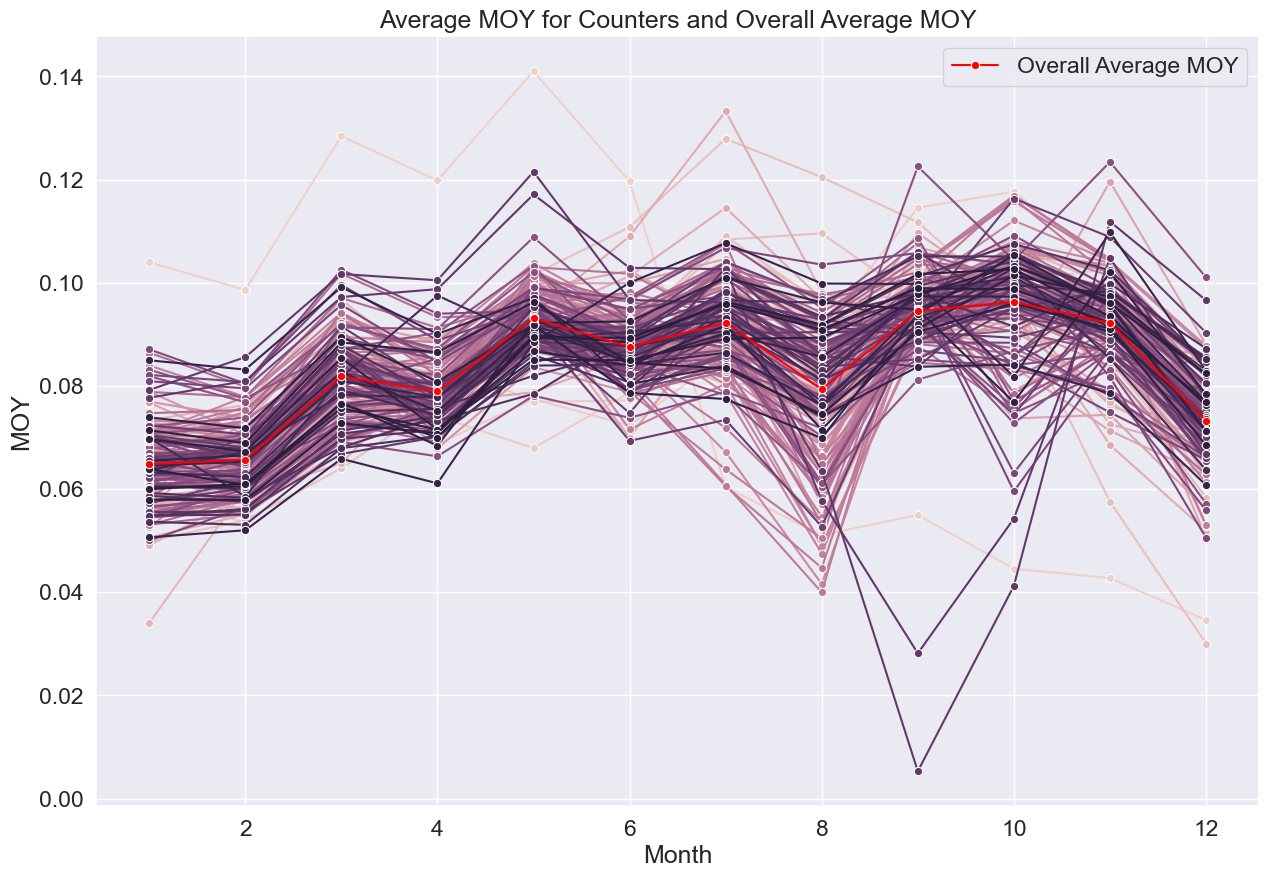

In [16]:
# Set plot parameters
sns.set(rc={'figure.figsize': (15, 10)})
sns.set(font_scale=1.5)

# Create the plot
fig, ax = plt.subplots()

# Plot individual counters' Average MOY
sns.lineplot(x='month', y='MOY', hue='id', data=moy_factor, markers=True, marker="o", dashes=False, sort=True, ax=ax, legend=False)

# Calculate and plot the average MOY
average_moy = moy_factor.groupby('month')['MOY'].mean().reset_index()
sns.lineplot(x='month', y='MOY', data=average_moy, markers=True, marker="o", dashes=False, sort=True, ax=ax, color='red', label='Overall Average MOY')

# Set title
ax.set_title('Average MOY for Counters and Overall Average MOY')

# Set axis labels
ax.set_ylabel('MOY')
ax.set_xlabel('Month')

# Show plot
plt.show()


## Summary Expansion Factors

In [17]:
# Initialize an empty list to store the summary statistics
summary_stats = []

#List of expansion factors
EX= [hod_weekday,hod_weekend,dow_factor,moy_factor]

# Loop through each dataframe in the list EX
for ex in EX:
    # Get the summary statistics of the last column
    stats = ex.iloc[:, -1].describe()
    # Add the number of unique counters to the summary statistics
    stats['num_counters'] = ex['id'].nunique()
    # Append the summary statistics to the list
    summary_stats.append(stats)

# Convert the list of summary statistics to a dataframe
summary_df = pd.DataFrame(summary_stats)

# Display the summary dataframe
summary_df


,count,mean,std,min,25%,50%,75%,max,num_counters
HOD,8736.0,0.041667,0.025464,0.000531,0.016846,0.043874,0.062830,0.188991,364.0
HOD,8736.0,0.041667,0.023139,0.001334,0.018772,0.045764,0.060842,0.150109,364.0
DOW,2548.0,0.142857,0.019989,0.067006,0.129455,0.149913,0.157259,0.197705,364.0
MOY,2232.0,0.083333,0.014010,0.005313,0.073832,0.085251,0.093580,0.141010,186.0


# Save output

In [18]:
# Save expansion factors separately
if SAVE_OUTPUT:
    hod_weekday.to_parquet(Path(OUTPUT_DATA_PATH) / f"hod_weekday_{YEAR}.parquet")
    hod_weekend.to_parquet(Path(OUTPUT_DATA_PATH) / f"hod_weekend_{YEAR}.parquet")
    dow_factor.to_parquet(Path(OUTPUT_DATA_PATH) / f"dow_factor_{YEAR}.parquet")
    moy_factor.to_parquet(Path(OUTPUT_DATA_PATH) / f"moy_factor_{YEAR}.parquet")
    
    hod_weekday.to_csv(Path(OUTPUT_DATA_PATH) / f"hod_weekday_{YEAR}.csv", index=False)
    hod_weekend.to_csv(Path(OUTPUT_DATA_PATH) / f"hod_weekend_{YEAR}.csv", index=False)
    dow_factor.to_csv(Path(OUTPUT_DATA_PATH) / f"dow_factor_{YEAR}.csv", index=False)
    moy_factor.to_csv(Path(OUTPUT_DATA_PATH) / f"moy_factor_{YEAR}.csv", index=False)


